In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.optimize import lsq_linear

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

In [2]:
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

In [3]:
def AR(data_series, p):
    data = pd.DataFrame(data_series.values, columns=["original"])
    if p == 0:
        data["predicted"] = data_series.mean()
        return data

    # set up the lags
    for lag in range(1, p+1):
        data[f"lag_{lag}"] = data["original"].shift(lag)

    # first column in data is the y
    y = data.iloc[p:, 0]
    X = data.iloc[p:, 1:]

    model = LinearRegression().fit(X, y)
    intercept = model.intercept_
    coefs = model.coef_
    print(intercept)
    print(coefs)
    predicted = X.dot(coefs.T) + intercept
    data["predicted"] = predicted
    #data[["original", "predicted"]].plot()
    #plt.show()
    return data
    

In [4]:
def MA(data_series, q):
    data = pd.DataFrame(data_series.values, columns=["error"])
    if q == 0:
        data["predicted"] = data_series.mean()
        return data

    # set up the lags
    for lag in range(1, q+1):
        data[f"lag_{lag}"] = data["error"].shift(lag)

    # first column in data is the y
    y = data.iloc[q:, 0]
    X = data.iloc[q:, 1:]

    model = LinearRegression().fit(X, y)
    intercept = model.intercept_
    coefs = model.coef_

    print(intercept)
    print(coefs)

    predicted = X.dot(coefs.T) + intercept
    data["predicted"] = predicted

    return data

In [ ]:
'''
def myARIMA(data_series, p, d, q, plot=True):
    ar_coefs = None
    ma_coefs = None
    split = int(0.8 * len(data_series))

    # data = pd.DataFrame(data_series.values, columns=["original"])
    data = pd.DataFrame(data_series.values, index=data_series.index, columns=["original"])
    data["Diff"] = data["original"]
    for _ in range(d):
        data["Diff"] = data["Diff"].diff()

    mu = data["Diff"].mean()
    data["Diff"].fillna(mu)
    
    # ar = pd.DataFrame((data["Diff"]).values, columns=["original"])
    ar = pd.DataFrame((data["Diff"]).values, index=data.index, columns=["original"])
    if p == 0:
        ar["predicted"] = mu
    else:
        # set up the lags
        # print(ar["original"].shift(1, freq="infer"))
        shifted = ar["original"].shift(1, freq="infer")
        for lag in range(1, p+1):
            # ar[f"lag_{lag}"] = ar["original"].shift(lag, freq="infer")
            test = shifted
            test_df = pd.DataFrame(test.values, index=test.index, columns=[f"lag_{lag}"])
            ar = pd.concat([ar, test_df], axis=1)
            shifted = shifted.shift(1)
        ar = ar.fillna(0)

        # get X and y
        X = ar.loc[data.index].iloc[:, 1:]
        y = ar.loc[data.index].iloc[:, 0]

        ar_coefs = lsq_linear(X, y).x
        ar["predicted"] = X.dot(ar_coefs.T)
    
    data["AR_predicted"] = ar["predicted"]

    # ma = pd.DataFrame((ar["original"] - ar["predicted"]).values, columns=["error"])
    # print(ar)
    ma = pd.DataFrame((ar["original"].loc[data.index] - ar["predicted"].loc[data.index]).values, index=data_series.index, columns=["error"])

    if q == 0:
        # ma["predicted"] = ma["error"].mean()
        ma["predicted"] = 0
    else:
        # set up the lags
        shifted = ma["error"].shift(1, freq="infer")
        for lag in range(1, q+1):
            # ma[f"lag_{lag}"] = ma["error"].shift(lag, freq="infer")
            test = shifted
            test_df = pd.DataFrame(test.values, index=test.index, columns=[f"lag_{lag}"])
            ma = pd.concat([ma, test_df], axis=1)
            shifted = shifted.shift(1)

        ma = ma.fillna(0)
        # get X and y
        X = ma.loc[data.index].iloc[:, 1:]
        y = ma.loc[data.index].iloc[:, 0]

        ma_coefs = lsq_linear(X, y).x
        ma["predicted"] = X.dot(ma_coefs.T)
    # print(ma)
    data["MA_predicted"] = ma["predicted"]
    # Can't handle d > 1 at the moment lol
    if d == 1:
        data["predicted"] = data["original"].shift() + mu + data["AR_predicted"] + data["MA_predicted"]
    else:
        data["predicted"] = mu + data["AR_predicted"] + data["MA_predicted"]
    data = data.fillna(0)

    rmse_df = pd.DataFrame(data[["original", "predicted"]])
    rmse =  mean_squared_error(rmse_df["original"], rmse_df["predicted"])

    last_ar = ar.iloc[-1, 1:-1]
    last_ma = ma.iloc[-1, 1:-1]
    ar_pred = last_ar.dot(ar_coefs.T)
    ma_pred = last_ma.dot(ma_coefs.T)
    print(ar_pred, ma_pred, mu)
    

    if plot:
        ar[["original", "predicted"]].plot()
        plt.show()

        ma[["error"]].plot(kind="kde")
        plt.show()

        ma[["error", "predicted"]].plot()
        plt.show()

        data[["original", "predicted"]].plot()
        plt.show()
        
    return data, ar_coefs, ma_coefs, rmse, ar, ma

'''

In [308]:
def myARIMA(data_series, p, d, q, plot=True):
    ar_coefs = None
    ma_coefs = None
    split = int(0.8 * len(data_series))

    # data = pd.DataFrame(data_series.values, columns=["original"])
    data_series = data_series.asfreq('MS')

    train = data_series.iloc[:split]
    test_X = data_series.iloc[split:]
    
    data = pd.DataFrame(train.values, index=train.index, columns=["original"])
    data["Diff"] = data["original"]
    for _ in range(d):
        data["Diff"] = data["Diff"].diff()

    mu = data["Diff"].mean()
    data["Diff"].fillna(mu)
    
    # ar = pd.DataFrame((data["Diff"]).values, columns=["original"])
    ar = pd.DataFrame((data["Diff"]).values, index=data.index, columns=["original"])
    if p == 0:
        ar["predicted"] = mu
    else:
        # set up the lags
        # print(ar["original"].shift(1, freq="infer"))
        shifted = ar["original"].shift(1, freq="infer")
        for lag in range(1, p+1):
            # ar[f"lag_{lag}"] = ar["original"].shift(lag, freq="infer")
            test = shifted
            test_df = pd.DataFrame(test.values, index=test.index, columns=[f"lag_{lag}"])
            ar = pd.concat([ar, test_df], axis=1)
            shifted = shifted.shift(1)
        ar = ar.fillna(0)

        # get X and y
        X = ar.loc[data.index].iloc[:, 1:]
        y = ar.loc[data.index].iloc[:, 0]

        ar_coefs = lsq_linear(X, y).x
        ar["predicted"] = X.dot(ar_coefs.T)
    
    data["AR_predicted"] = ar["predicted"]

    # ma = pd.DataFrame((ar["original"] - ar["predicted"]).values, columns=["error"])
    # print(ar)
    ma = pd.DataFrame((ar["original"].loc[data.index] - ar["predicted"].loc[data.index]).values, index=train.index, columns=["error"])

    if q == 0:
        # ma["predicted"] = ma["error"].mean()
        ma["predicted"] = 0
    else:
        # set up the lags
        shifted = ma["error"].shift(1, freq="infer")
        for lag in range(1, q+1):
            # ma[f"lag_{lag}"] = ma["error"].shift(lag, freq="infer")
            test = shifted
            test_df = pd.DataFrame(test.values, index=test.index, columns=[f"lag_{lag}"])
            ma = pd.concat([ma, test_df], axis=1)
            shifted = shifted.shift(1)

        ma = ma.fillna(0)
        # get X and y
        X = ma.loc[data.index].iloc[:, 1:]
        y = ma.loc[data.index].iloc[:, 0]

        ma_coefs = lsq_linear(X, y).x
        ma["predicted"] = X.dot(ma_coefs.T)
    # print(ma)
    data["MA_predicted"] = ma["predicted"]
    # Can't handle d > 1 at the moment lol
    if d == 1:
        data["predicted"] = data["original"].shift() + mu + data["AR_predicted"] + data["MA_predicted"]
    else:
        data["predicted"] = mu + data["AR_predicted"] + data["MA_predicted"]
    data = data.fillna(0)

    rmse_df = pd.DataFrame(data[["original", "predicted"]])
    rmse =  mean_squared_error(rmse_df["original"], rmse_df["predicted"])
    
    # print(data)
    last_ar = ar.iloc[-1, 1:-1]
    last_ma = ma.iloc[-1, 1:-1]
    ar_pred = last_ar.dot(ar_coefs.T) if ar_coefs else mu
    ma_pred = last_ma.dot(ma_coefs.T) if ma_coefs else 0
    # print(ar_pred, ma_pred, mu)
    last_obs = data["original"][-1]

    pred = last_obs + mu + ar_pred + ma_pred
    new_obs = test_X.iloc[0].values[0]

    data.loc[data.index[-1] + data.index.freq] = [new_obs, pred - last_obs, ar_pred, ma_pred, pred]

    if plot:
        ar[["original", "predicted"]].plot()
        plt.show()

        ma[["error"]].plot(kind="kde")
        plt.show()

        ma[["error", "predicted"]].plot()
        plt.show()

        data[["original", "predicted"]].plot()
        plt.show()
        
    return data, ar_coefs, ma_coefs, rmse, ar, ma



49.01437354776785
[-1.20120726 -0.76324691 -0.4629424  -0.190935    0.13666708]


<AxesSubplot:>

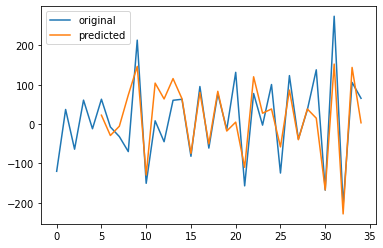

In [259]:
data = pd.read_csv("shampoo.csv", header=0, index_col=0, parse_dates=True, date_parser=parser)
first = data.diff(1).dropna()
ar1 = AR(first, 5)
ar1[["original", "predicted"]].plot()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -196.631
Date:                Mon, 25 Oct 2021   AIC                            401.263
Time:                        15:52:56   BIC                            407.484
Sample:                             0   HQIC                           403.411
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0894      0.346      0.258      0.796      -0.589       0.768
ma.L1         -1.3186      2.951     -0.447      0.655      -7.103       4.466
ma.L2          0.9944      4.393      0.226      0.8

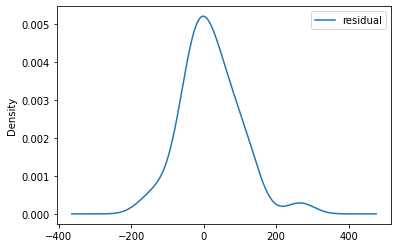

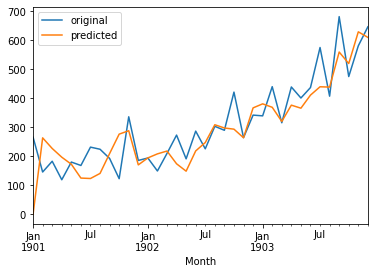

In [162]:
model = ARIMA(data.values, order=(1,1,2))
# model = ARIMA(first.values, order=(1,1,2))
fitted = model.fit()
print(fitted.summary())
print(fitted.resid)
pd.DataFrame(fitted.resid, columns=["residual"]).plot(kind="kde")
predicted = fitted.predict(start=0, end=len(first))
# predicted = fitted.predict(start=0, end=len(first)-1)
df = pd.DataFrame()
df["original"] = data.Sales
# df["original"] = first
df["predicted"] = predicted
df[["original", "predicted"]].plot()
print("Mean squared error:", mean_squared_error(df["original"], df["predicted"]))


[401.3, -68.23005040560491, 6.41851851851852, -81.0670874426419, 371.0699495943951]


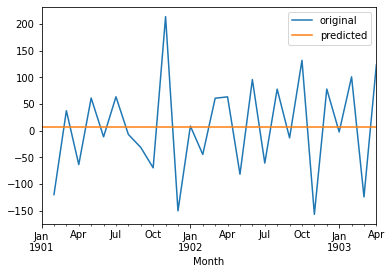

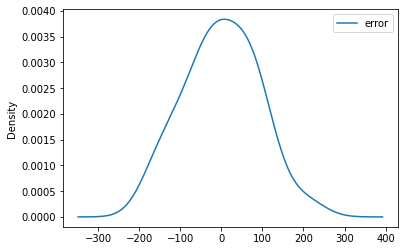

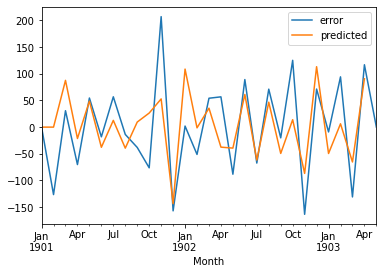

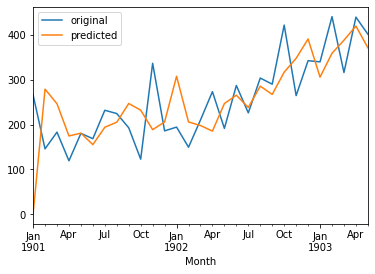

AR coefs: None
MA coefs: [-0.69299077]
Mean squared error: 7021.91033823644


In [310]:
res, ar_coefs, ma_coefs, rmse, ar, ma = myARIMA(data, 0,1,1)
print("AR coefs:", ar_coefs)
print("MA coefs:", ma_coefs)
print("Mean squared error:", rmse)

In [304]:
res

,original,Diff,AR_predicted,MA_predicted,predicted
Month,,,,,
1901-01-01,266.0,0.000000,6.418519,0.0,0.000000
1901-02-01,145.9,-120.100000,6.418519,0.0,278.837037
1901-03-01,183.1,37.200000,6.418519,0.0,158.737037
1901-04-01,119.3,-63.800000,6.418519,0.0,195.937037
1901-05-01,180.3,61.000000,6.418519,0.0,132.137037
1901-06-01,168.5,-11.800000,6.418519,0.0,193.137037
1901-07-01,231.8,63.300000,6.418519,0.0,181.337037
1901-08-01,224.5,-7.300000,6.418519,0.0,244.637037
1901-09-01,192.8,-31.700000,6.418519,0.0,237.337037


In [10]:
from pmdarima.arima import auto_arima
mod = auto_arima(data.values)
print(mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -195.731
Date:                Mon, 25 Oct 2021   AIC                            401.463
Time:                        13:38:45   BIC                            409.240
Sample:                             0   HQIC                           404.147
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.3051      6.175      1.507      0.132      -2.798      21.408
ar.L1          0.0890      0.314      0.284      0.777      -0.526       0.704
ma.L1         -1.3867      0.314     -4.411      0.0

/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


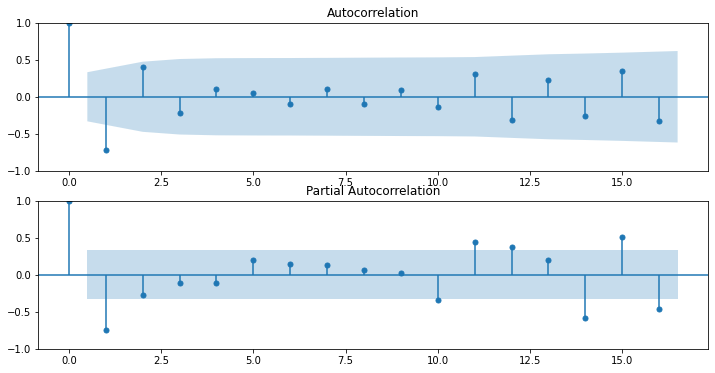

In [11]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(first.dropna(), ax=ax[0], lags=16)
ax[1] = plot_pacf(first.dropna(), ax=ax[1], lags=16)

/home/mjuan23/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


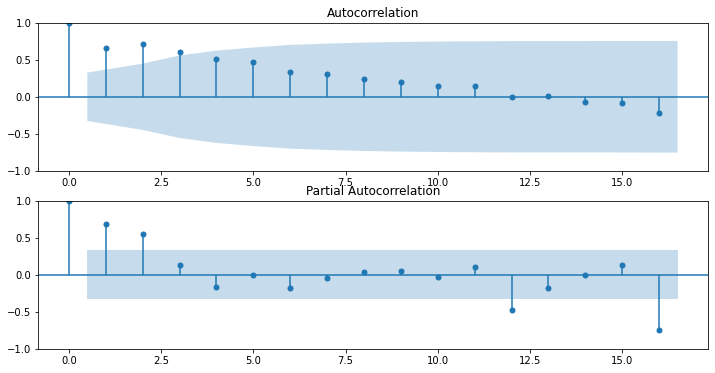

In [12]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(data.dropna(), ax=ax[0], lags=16)
ax[1] = plot_pacf(data.dropna(), ax=ax[1], lags=16)